In [17]:
import sys
import calendar
import glob

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs

sys.path.append('/g/data/xv83/quantile-mapping/qqscale')
import utils

In [2]:
qq_cmatch_files = sorted(glob.glob("/g/data/ia39/australian-climate-service/test-data/QDC-CMIP6-v2/BARRA-R2/MPI-ESM1-2-HR/ssp370/r1i1p1f1/day/pr/2070-2099/pr_day_MPI-ESM1-2-HR_ssp370_r1i1p1f1_AUS-11_*_qdc-multiplicative-monthly-q100-linear-maxaf5-annual-change-matched_BARRA-R2-baseline-1985-2014_model-baseline-1985-2014.nc"))
hist_files = sorted(glob.glob("/g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/day/pr/gn/v20190710/*.nc"))
ref_files = sorted(glob.glob("/g/data/oi10/replicas/CMIP6/ScenarioMIP/DKRZ/MPI-ESM1-2-HR/ssp370/r1i1p1f1/day/pr/gn/v20190710/*.nc"))
target_files = sorted(glob.glob("/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/pr/v20240809/pr_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_*.nc"))

In [4]:
ds_hist = utils.read_data(
    hist_files,
    'pr',
    time_bounds=['1985', '2014'],
    input_units="kg m-2 s-1",
    output_units="mm day-1",
)
try:
    ds_hist = ds_hist.drop_vars('crs')
except ValueError:
    pass

In [5]:
ds_ref = utils.read_data(
    ref_files,
    'pr',
    time_bounds=['2070', '2099'],
    input_units="kg m-2 s-1",
    output_units="mm day-1",
)
try:
    ds_ref = ds_ref.drop_vars('crs')
except ValueError:
    pass

In [6]:
ds_target = utils.read_data(
    target_files,
    'pr',
    time_bounds=['1985', '2014'],
    input_units="kg m-2 s-1",
    output_units="mm day-1",
)
try:
    ds_target = ds_target.drop_vars('crs')
except ValueError:
    pass

In [7]:
ds_qq = utils.read_data(
    qq_cmatch_files,
    'pr',
    time_bounds=['2070', '2099'],
)
try:
    ds_qq = ds_qq.drop_vars('crs')
except ValueError:
    pass

In [27]:
city_lat_lon = {
    'Hobart': (-42.9, 147.3),
    'Melbourne': (-37.8, 145.0),
    'Mildura': (-34.2, 142.1),
    'Thredbo': (-36.5, 148.3),
    'Sydney': (-33.9, 151.2),
    'Brisbane': (-27.5, 153.0),
    'Cairns': (-16.9, 145.8),
    'Mount_Isa': (-20.8, 139.5), 
    'Darwin': (-12.5, 130.8),
    'Alice_Springs': (-23.7, 133.9),
    'Port_Hedland': (-20.3, 118.6),
    'Karlamilyi_National_Park': (-22.7, 122.2),
    'Perth': (-32.0, 115.9),
    'Adelaide': (-34.9, 138.6),
}

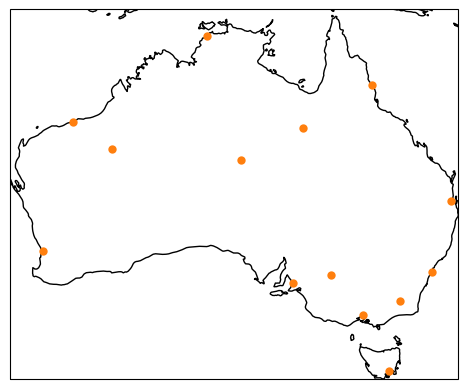

In [24]:
fig = plt.figure()#figsize=[24, 6])

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.coastlines()

for city in city_lat_lon:
    lat, lon = city_lat_lon[city]
    ax.plot(
        lon,
        lat,
        marker='o',
        markerfacecolor='tab:orange',
        markeredgecolor='none',
#        zorder=5,
#        label=city,
        transform=ccrs.PlateCarree()
    )
#ax.legend()
xmin = 112.92
xmax = 153.63
ymin = -43.625
ymax = -10.07
ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())
plt.show()

In [25]:
def plot_city(city):
    """Plot a location"""
    
    lat, lon = city_lat_lon[city]
    point_selection = {'lat': lat, 'lon': lon}
    
    da_hist_point = ds_hist['pr'].sel(point_selection, method='nearest')
    da_ref_point = ds_ref['pr'].sel(point_selection, method='nearest')
    da_target_point = ds_target['pr'].sel(point_selection, method='nearest')
    da_qq_point = ds_qq['pr'].sel(point_selection, method='nearest')
    
    da_hist_point_monthly = da_hist_point.resample(time='M').sum(dim='time', keep_attrs=True)
    da_ref_point_monthly = da_ref_point.resample(time='M').sum(dim='time', keep_attrs=True)
    da_target_point_monthly = da_target_point.resample(time='M').sum(dim='time', keep_attrs=True)
    da_qq_point_monthly = da_qq_point.resample(time='M').sum(dim='time', keep_attrs=True)
    
    da_hist_point_clim = da_hist_point_monthly.groupby('time.month').mean('time').compute()
    da_ref_point_clim = da_ref_point_monthly.groupby('time.month').mean('time').compute()
    da_target_point_clim = da_target_point_monthly.groupby('time.month').mean('time').compute()
    da_qq_point_clim = da_qq_point_monthly.groupby('time.month').mean('time').compute()
    
    xticks = np.arange(1, 13)
    xtick_labels = [calendar.month_abbr[i] for i in xticks]

    fig = plt.figure()#figsize=[])
    plt.plot(xticks, da_hist_point_clim, label='model: historical (1985-2014)', linestyle=':', color='tab:orange', marker='o')
    plt.plot(xticks, da_ref_point_clim, label='model: SSP3-7.0 (2070-2099)', linestyle='-', color='tab:orange', marker='o')
    plt.plot(xticks, da_target_point_clim, label='BARRA-R2 (1985-2014)', linestyle=':', color='tab:blue', marker='o')
    plt.plot(xticks, da_qq_point_clim, label='QDC (2070-2099)', linestyle='-', color='tab:blue', marker='o')

    plt.title(city.replace('_', ' '))
    plt.legend()
    plt.ylabel('monthly mean precipitation (mm)')
    plt.xticks(xticks, xtick_labels)
    plt.grid()
#    plt.savefig(
#        f'pr_monthly-clim_MPI-ESM1-2-HR_ssp370_r1i1p1f1_{city}_2070-2099_qdc-multiplicative-monthly-q100-linear-maxaf5-annual-change-matched_BARRA-R2-baseline-1985-2014_model-baseline-1985-2014.png',
#        bbox_inches='tight',
#        facecolor='white',
#        dpi=300
#    )
    plt.show()

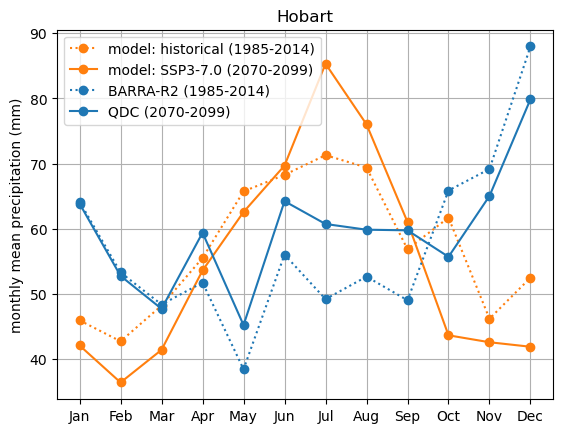

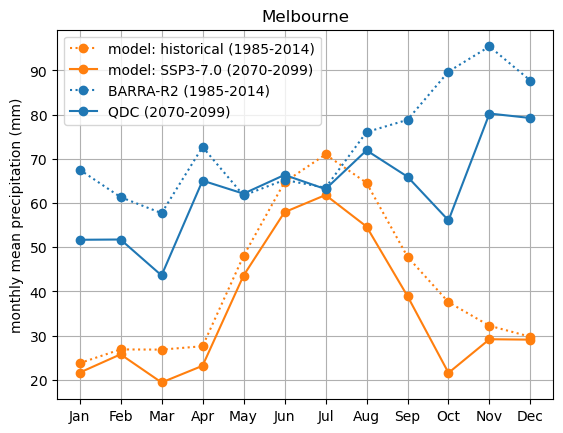

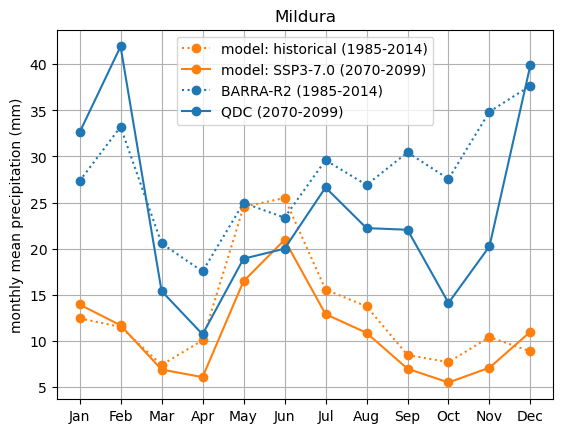

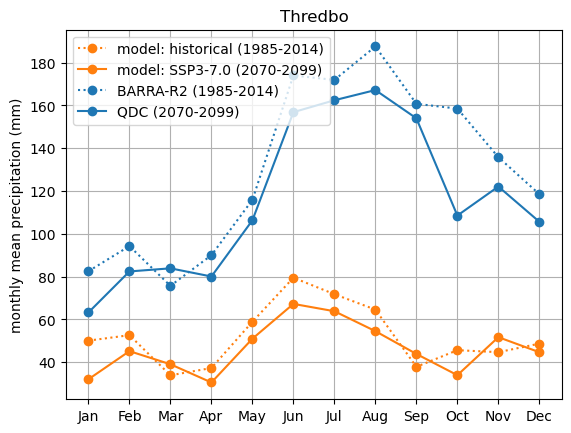

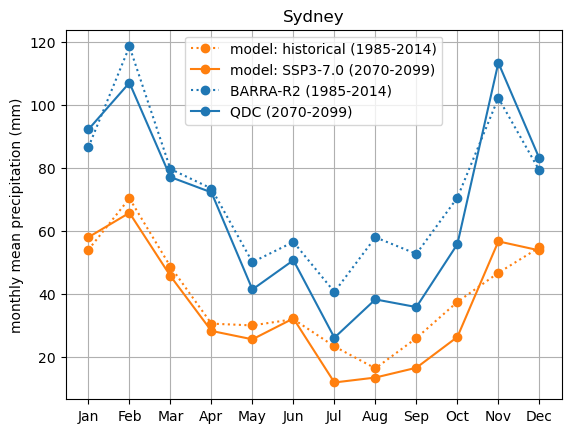

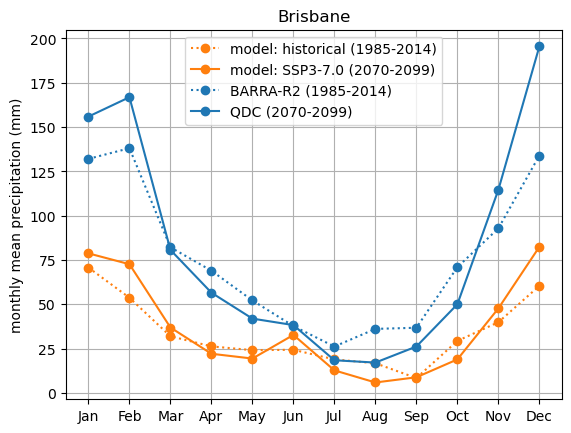

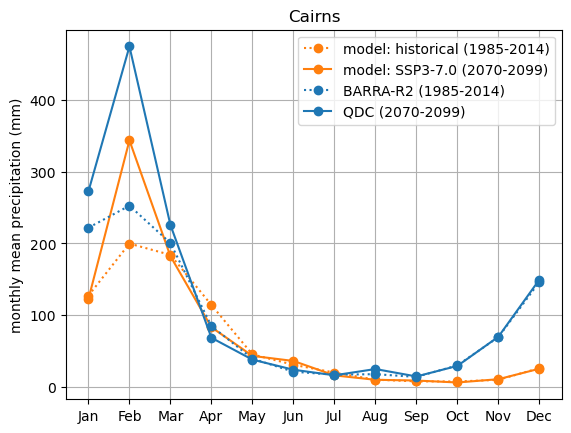

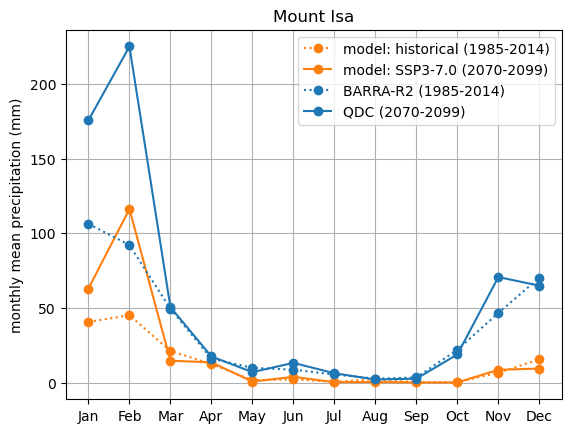

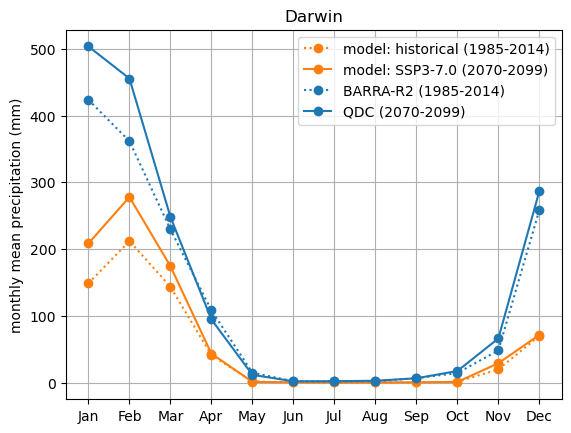

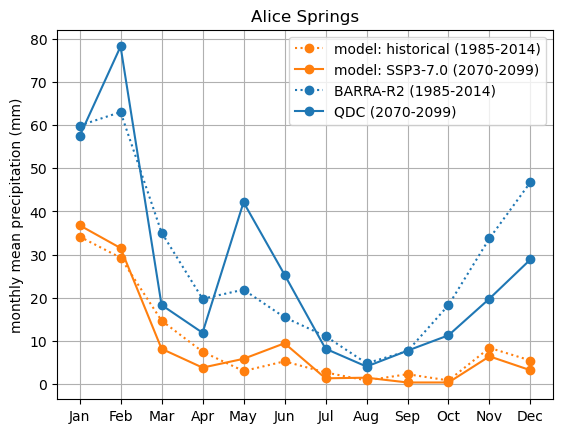

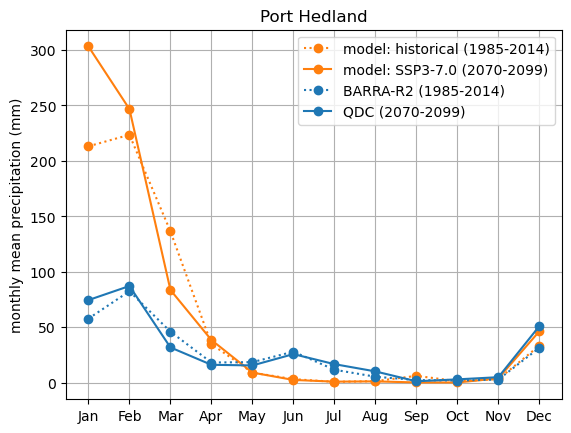

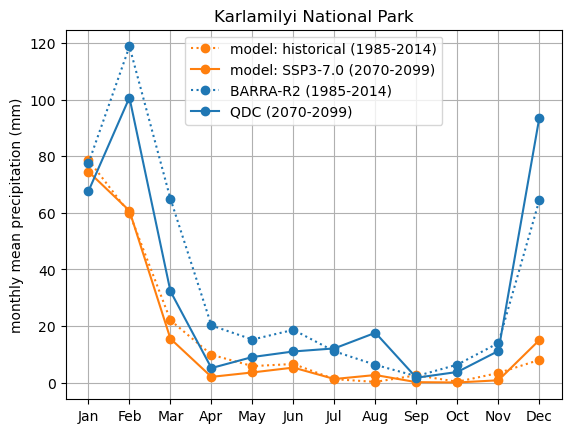

In [ ]:
for city in city_lat_lon:
    plot_city(city)